PyTorch functional ImageNet classification demo
==========

In [10]:
from PIL import Image
import requests
import numpy as np
from io import BytesIO
from torch.utils import model_zoo
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/szagoruy/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['load', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Pretrained weights

In [3]:
params = model_zoo.load_url('https://s3.amazonaws.com/modelzoo-networks/nin-export-e65df26d.pth')

for k,v in sorted(params.items()):
    print(k, tuple(v.shape))
    params[k] = Variable(v)

conv0.bias (96,)
conv0.weight (96, 3, 11, 11)
conv1.bias (96,)
conv1.weight (96, 96, 1, 1)
conv10.bias (1024,)
conv10.weight (1024, 1024, 1, 1)
conv11.bias (1024,)
conv11.weight (1024, 1024, 1, 1)
conv2.bias (96,)
conv2.weight (96, 96, 1, 1)
conv3.bias (256,)
conv3.weight (256, 96, 5, 5)
conv4.bias (256,)
conv4.weight (256, 256, 1, 1)
conv5.bias (256,)
conv5.weight (256, 256, 1, 1)
conv6.bias (384,)
conv6.weight (384, 256, 3, 3)
conv7.bias (384,)
conv7.weight (384, 384, 1, 1)
conv8.bias (384,)
conv8.weight (384, 384, 1, 1)
conv9.bias (1024,)
conv9.weight (1024, 384, 3, 3)
fc.bias (1000,)
fc.weight (1000, 1024)


### Model definition

In [25]:
def network_in_network(inputs, params):
    def conv2d(x, params, name, stride=1, padding=0):
        return F.conv2d(x,
                        params['%s.weight'%name],
                        params['%s.bias'%name], stride, padding)

    def block(x, names, stride, padding):
        x = F.relu(conv2d(x, params, names[0], stride, padding))
        x = F.relu(conv2d(x, params, names[1]))
        x = F.relu(conv2d(x, params, names[2]))
        return x

    o = block(inputs, ['conv0', 'conv1', 'conv2'], 4, 5)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv3', 'conv4', 'conv5'], 1, 2)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv6', 'conv7', 'conv8'], 1, 1)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv9', 'conv10', 'conv11'], 1, 1)
    o = F.avg_pool2d(o, 7)
    o = o.view(o.size(0), -1)
    o = F.linear(o, params['fc.weight'], params['fc.bias'])
    return o

### Load an image

In [11]:
def load(url):
    response = requests.get(url)
    return np.ascontiguousarray(Image.open(BytesIO(response.content)), dtype=np.uint8)

im = load('http://www.zooclub.ru/attach/26000/26132.jpg')

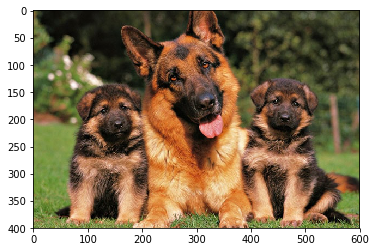

In [12]:
plt.imshow(im)

In [21]:
tr_center_crop = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [41]:
def classify(x):
    with open('synset_words.txt') as h:
        synset_words = [s[10:-1] for s in h.readlines()]

    with torch.no_grad():
        y = network_in_network(Variable(x.unsqueeze(0)), params)
        probs, idx = F.softmax(y, dim=1).data.squeeze(0).sort(0,True)

    print('\n'.join('%.2f: %s' % (p, synset_words[class_id])
                    for p, class_id in zip(probs[:5], idx[:5])))

classify(tr_center_crop(im))

0.99: German shepherd, German shepherd dog, German police dog, alsatian
0.01: malinois
0.00: Norwegian elkhound, elkhound
0.00: Leonberg
0.00: red wolf, maned wolf, Canis rufus, Canis niger
